# “添翼杯”人工智能创新应用大赛-智慧教育赛道

# 作者：Cyber1987

# 一、赛题描述

请参赛选手，利用比赛对应训练集提供的学生信息、考试知识点信息、考试总得分信息等建立模型，预测测试集中学生在指定考试中的成绩总分，预测目标如下：

初赛：利用初中最后一年的相关考试和考点信息，预测初中最后一学期倒数第二、第三次考试的成绩。

# 二、训练集

student.csv 学生信息

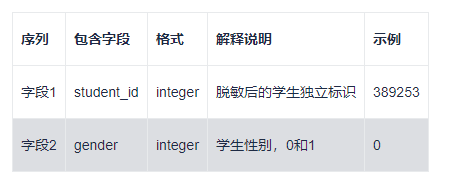

course.csv 课程信息
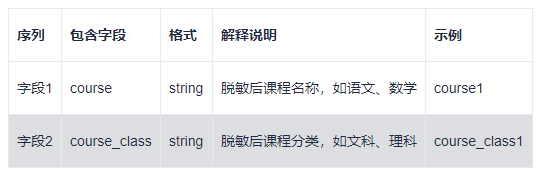

all_knowledge.csv 知识点信息
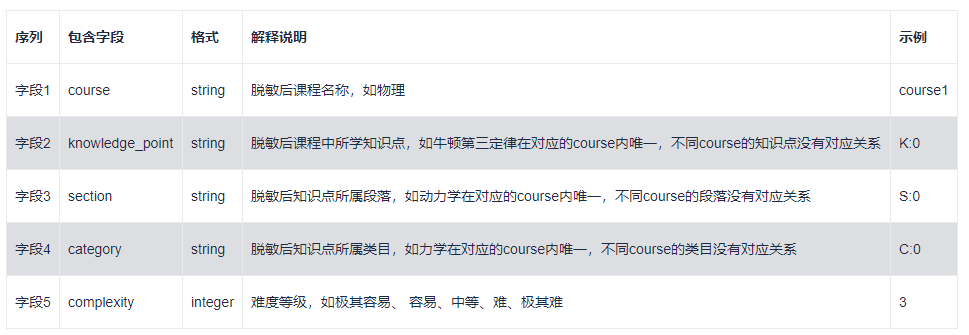

course*_exams.csv 试卷信息
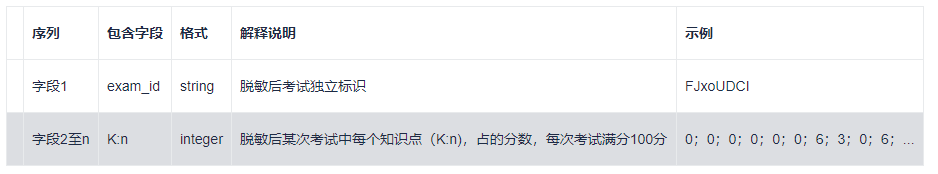

exam_score_s1.csv（初赛） 和 exam_score.csv（复赛） 得分信息
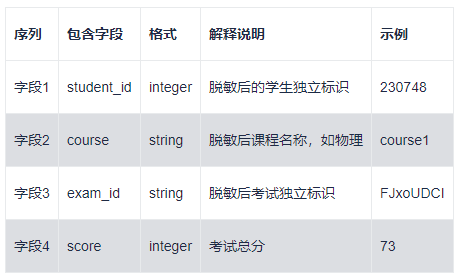

# 三、测试集

submission_s1.csv（初赛） 和 submission_s2.csv （复赛）
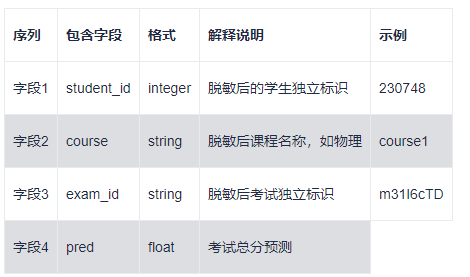

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
train_path = os.path.abspath('.') + '\\train_s1'
test_path = os.path.abspath('.') + '\\test_s1'

In [3]:
all_knowledge = pd.read_csv(train_path + '\\' + 'all_knowledge.csv')
course = pd.read_csv(train_path + '\\' + 'course.csv')
exam_score = pd.read_csv(train_path + '\\' + 'exam_score.csv')
student = pd.read_csv(train_path + '\\' + 'student.csv')
submission_s1 = pd.read_csv(test_path + '\\' + 'submission_s1.csv')

# 四、赛题分析

初赛：利用初中最后一年的相关考试和考点信息，预测初中最后一学期倒数第二、第三次考试的成绩。

1、因为是第二、第三次考试，所以知识点的影响可能会比较小，因为第二、三次的考试知识点大部分都是全新的，只有很少一部分是之前的知识点；

2、但是因为知识点往往集中在同一个category（类目），所以可以把这些知识点进行数据整合；

3、性别可能是影响成绩的要素之一，可以先做一下数据分析；

4、上一次考试的成绩有可能也是影响要素之一，作为备选特征

# 五、数据清洗

1、首先观察一下exam_score的数据分布情况

In [4]:
exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65500 entries, 0 to 65499
Data columns (total 4 columns):
student_id    65500 non-null int64
course        65500 non-null object
exam_id       65500 non-null object
score         65500 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


分析：可以看到并没有缺失值

In [5]:
#再看看各个分数的情况
print(exam_score.score.value_counts().to_dict())

{82: 2563, 84: 2508, 83: 2494, 85: 2456, 79: 2442, 80: 2442, 81: 2439, 78: 2359, 86: 2314, 77: 2261, 87: 2244, 76: 2190, 88: 2167, 89: 2111, 75: 2004, 90: 1923, 74: 1901, 91: 1900, 95: 1886, 96: 1799, 92: 1769, 73: 1757, 97: 1679, 93: 1590, 98: 1581, 72: 1488, 99: 1477, 94: 1430, 71: 1420, 70: 1174, 69: 1046, 68: 807, 100: 684, 67: 683, 66: 581, 65: 504, 64: 347, 63: 274, 62: 198, 61: 155, 0: 150, 60: 94, 59: 77, 58: 51, 57: 27, 56: 26, 55: 14, 54: 8, 53: 3, 52: 2, 51: 1}


分析：有150个为0分，也就是相当于缺失值，考虑到score本来就是预测的选项，所以删除

# 六、特征工程

因为几张表格很分散，所以先做一下整合后，再做数据分析

## 1、获得每个学生每门课程的上一次考试成绩

In [7]:
#获得new_exam_score；获得最近1次成绩作为last_score
course_list = ['course1', 'course2', 'course3', 'course4', 'course5', 'course6', 'course7', 'course8']

exam_score = exam_score[exam_score.score != 0] #删除0分的行
# exam_score[exam_score.score == 0] = np.nan
exam_score['last_score'] = 0
new_exam_score = pd.DataFrame(columns=('student_id', 'course', 'exam_id', 'score', 'last_score'))
for student_id in student['student_id']:
    for course_id in course_list:
        exam_score_temp = exam_score[(exam_score.student_id == student_id) & (exam_score.course == course_id)]
        exam_score_temp = exam_score_temp.fillna(exam_score_temp['score'].mean()) #这句看起来没作用，但是删掉的话速度会慢很多很多
        exam_score_temp.reset_index(drop=True, inplace=True)
        temp_length = len(exam_score_temp)
        for i in range(temp_length):
            if i == 0:
                exam_score_temp.ix[i, 4] = exam_score_temp.ix[i, 3]
            else:
                exam_score_temp.ix[i, 4] = exam_score_temp.ix[(i-1), 3]
        last_score = exam_score_temp.ix[temp_length-1, 3]
        submission_s1.loc[(submission_s1['student_id'] == student_id) & (submission_s1['course'] == course_id), 'last_score'] = last_score
        new_exam_score = pd.concat([new_exam_score, exam_score_temp], axis=0)
#         print(new_exam_score.shape)
new_exam_score.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,student_id,course,exam_id,score,last_score
0,230748,course1,pNdxJnEf,67,67
1,230748,course1,5Sh31xmN,69,67
2,230748,course1,4CHUDKzQ,70,69
3,230748,course1,as7yltQJ,82,70
4,230748,course1,AFnBGQxE,75,82


## 2、获得每一次考试的上一次考试排名

In [8]:
#1.1、获得exam_score里所有的exam_id
train_exam_id_list = list(exam_score['exam_id'].unique())

#1.2获得每一次考试的上一次考试排名
# exam_score = exam_score[~exam_score['score'].isin([0])] #删除分数为0的行
exam_score_rank = pd.DataFrame(columns=['student_id', 'course', 'exam_id', 'score', 'last_score', 'last_rank'])
for exam_id in train_exam_id_list:
    exam_score_temp = new_exam_score[new_exam_score.loc[:, 'exam_id'] == exam_id]
    exam_score_temp.loc[:, 'last_rank'] = exam_score_temp.loc[:, 'last_score'].rank(method='min', ascending=False)
    exam_score_rank = pd.concat([exam_score_rank, exam_score_temp[['student_id', 'course', 'exam_id', 'score', 'last_score', 'last_rank']]], axis=0, sort=False)

exam_score_rank = exam_score_rank[['student_id', 'course', 'exam_id', 'score', 'last_score', 'last_rank']]
print(exam_score_rank.head())

#2.1同上，获得submission_s2里上次考试的排名
test_exam_id_list = list(submission_s1['exam_id'].unique())

#2.2获得每一次考试的排名
submission_score_rank = pd.DataFrame(columns=['student_id', 'course', 'exam_id', 'pred', 'last_score', 'last_rank'])
for exam_id in test_exam_id_list:
    submission_score_temp = submission_s1[submission_s1.loc[:, 'exam_id'] == exam_id]
    submission_score_temp.loc[:, 'last_rank'] = submission_score_temp.loc[:, 'last_score'].rank(method='min', ascending=False)
    submission_score_rank = pd.concat([submission_score_rank, submission_score_temp[['student_id', 'course', 'exam_id', 
    'pred', 'last_score', 'last_rank']]], axis=0, sort=False)
submission_score_rank['student_id'] = submission_score_rank['student_id'].astype(int)
submission_score_rank = submission_score_rank[['student_id', 'course', 'exam_id', 'pred', 'last_score', 'last_rank']]
submission_score_rank.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


  student_id   course   exam_id score last_score  last_rank
0     230748  course1  pNdxJnEf    67         67      477.0
0     186851  course1  pNdxJnEf    74         74      395.0
0     478370  course1  pNdxJnEf    74         74      395.0
0     692328  course1  pNdxJnEf    89         89      124.0
0     509128  course1  pNdxJnEf    84         84      213.0


,student_id,course,exam_id,pred,last_score,last_rank
0,230748,course1,m31I6cTD,NaN,90.0,239.0
1,186851,course1,m31I6cTD,NaN,88.0,282.0
2,478370,course1,m31I6cTD,NaN,86.0,321.0
3,692328,course1,m31I6cTD,NaN,84.0,356.0
4,509128,course1,m31I6cTD,NaN,89.0,265.0


## 3、先获得每门课的难度值

In [9]:
course_exams_complexity = pd.DataFrame(columns=['exam_id', 'sum_complexity'])
for course in course_list:
    all_knowledge_temp = all_knowledge[all_knowledge['course'] == course][['complexity']]
    course_exams_temp = pd.read_csv(train_path + '\\'+ course + '_exams.csv')
    course_exams_temp['sum_complexity'] = np.dot(course_exams_temp.iloc[:, 1:], all_knowledge_temp)
    course_exams_temp = course_exams_temp[['exam_id', 'sum_complexity']]
    course_exams_complexity = pd.concat([course_exams_complexity, course_exams_temp], axis=0)
course_exams_complexity.head()

,exam_id,sum_complexity
0,XBQWgzwe,237
1,Y7dW6m3f,320
2,HMA5ojir,272
3,FJxoUDCI,283
4,AgUNISQG,159


## 4、将每门课属于哪一类（category）提取出来

In [10]:
#获得与测试集、初赛有关的exam_id
train_exam_id_list = list(exam_score['exam_id'].unique()) #131个
test_exam_id_list = list(submission_s1['exam_id'].unique()) #16个
total_exam_id_list = train_exam_id_list + test_exam_id_list #147个

#获取每一门考试最有关联的8个知识点（category）
'''先新增n列category，列名是C:n，值都是0，然后遍历原列名（都是K:n），与字典{knowledge_point : category}进行比对，把该列的值都加入到所对应的C:n下'''
total_course_exams = pd.DataFrame(columns=('exam_id', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'))
for course in course_list:
    course_exams_temp = pd.read_csv(train_path + '\\'+ course + '_exams.csv')
    old_length = course_exams_temp.shape[1] #原来course_exams中的列数
    all_knowledge_temp = all_knowledge[all_knowledge['course'] == course][['knowledge_point', 'category']].set_index(
        'knowledge_point')
    length = len(all_knowledge_temp['category'].unique()) #category的个数
    temp_dict = all_knowledge_temp.to_dict()['category']
    for i in range(0, length): #增加C:n列
        course_exams_temp['C:' + str(i)] = 0
    for j in range(1, old_length): #遍历原来course_exams中的列数
        for k in range(0, length): #遍历category的个数
            if 'C:' + str(k) == temp_dict['K:' + str(j-1)]:
                temp_C = k+old_length
                course_exams_temp['C:' + str(k)] = course_exams_temp['C:' + str(k)] + course_exams_temp['K:' + str(j-1)]
                break
    course_exams_temp = pd.concat([course_exams_temp['exam_id'], course_exams_temp.iloc[:, old_length:]], axis=1)
    course_exams_temp = course_exams_temp[course_exams_temp['exam_id'].isin(total_exam_id_list)] #只保留有用的exam_id
    ## course_exams_temp = course_exams_temp.ix[:, ~(course_exams_temp == 0).all()] #删除所有数值都为0的列，注：这里可以看到最多只需要保存后8列即可
    course_exams_temp = pd.concat([course_exams_temp['exam_id'], course_exams_temp.iloc[:, -8:]], axis=1)
    course_exams_temp.columns = ['exam_id', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
    total_course_exams = pd.concat([total_course_exams, course_exams_temp], axis=0)
total_course_exams.head() #有九列：exam_id，以及最后8个category数值（0-100分）

,exam_id,C1,C2,C3,C4,C5,C6,C7,C8
64,pNdxJnEf,0,0,0,100,0,0,0,0
65,5Sh31xmN,0,0,0,100,0,0,0,0
66,4CHUDKzQ,0,0,0,100,0,0,0,0
67,as7yltQJ,0,0,0,15,85,0,0,0
68,AFnBGQxE,0,0,0,79,21,0,0,0


## 5、获得每门课难度值的占比

In [11]:
total_exam_level = pd.DataFrame(columns=['level_0', 'level_1', 'level_2', 'level_3', 'level_4'])
for course in course_list:
    course_exams_temp = pd.read_csv(train_path + '\\'+ course + '_exams.csv')
    course_exams_temp_T = pd.DataFrame(course_exams_temp.values.T, index=course_exams_temp.columns, columns=course_exams_temp.exam_id)
    all_knowledge_temp = all_knowledge[all_knowledge.course == course][['knowledge_point', 'complexity']].set_index('knowledge_point')
    course_exams_temp_T = pd.merge(course_exams_temp_T, all_knowledge_temp, left_index=True, right_index=True)
    level_sum = pd.DataFrame(columns=course_exams_temp_T.columns)
    level_sum['level_0'] =course_exams_temp_T[course_exams_temp_T['complexity'] == 0].apply(lambda x: x.sum())
    level_sum['level_1'] =course_exams_temp_T[course_exams_temp_T['complexity'] == 1].apply(lambda x: x.sum())
    level_sum['level_2'] =course_exams_temp_T[course_exams_temp_T['complexity'] == 2].apply(lambda x: x.sum())
    level_sum['level_3'] =course_exams_temp_T[course_exams_temp_T['complexity'] == 3].apply(lambda x: x.sum())
    level_sum['level_4'] =course_exams_temp_T[course_exams_temp_T['complexity'] == 4].apply(lambda x: x.sum())
    level_sum = level_sum.iloc[:-1, -5:]
    total_exam_level = pd.concat([total_exam_level, level_sum], axis=0)
total_exam_level = total_exam_level.reset_index().rename(columns={'index': 'exam_id'})
total_exam_level.head()

,exam_id,level_0,level_1,level_2,level_3,level_4
0,XBQWgzwe,0,31,19,32,18
1,Y7dW6m3f,0,1,34,9,56
2,HMA5ojir,0,35,11,1,53
3,FJxoUDCI,0,0,50,17,33
4,AgUNISQG,20,27,27,26,0


## 6、获得每门课属于哪个学期、第几门考试等信息

In [12]:
def get_previous_big_exam(course_exam_number, max_row, max_col, this_big_exam_row, exams_level):
    '''
    :param course_exam_number: 考试类别
    :param max_row: 这门课程的最大行号
    :param max_col: 这门课程的最大列号
    :param this_big_exam_row: 大考的考试行号
    :param exams_level: 考试对应的层级，比如第一学期上半学期（term1_1）...第四学期下半学期（term4_2）
    :return: 上一门大考的行号
    '''
    #获得这一行最早的知识点
    for i in range(1, max_col):
        if course_exam_number.iloc[this_big_exam_row, i] > 0:
            earliest_col = i
            break
    #获得这个知识点最早的考试，进而推算出上一次大考的行号
    for j in range(0, max_row):
        if course_exam_number.iloc[j, earliest_col] > 1:
            if j == 0: previous_big_exam_row = 0
            elif course_exam_number.iloc[j-1, -5] < course_exam_number.iloc[j, -5]: previous_big_exam_row = j-2
            else: previous_big_exam_row = j-1
            if previous_big_exam_row > 1:
                course_exam_number.iloc[previous_big_exam_row, -4] = 'big'
                course_exam_number.iloc[previous_big_exam_row, -3] = 'term' + str(exams_level-1) + '_2' #上一次大考属于第几个学期的下半学期
                course_exam_number.iloc[previous_big_exam_row, -2] = 'term' + str(exams_level-1) #上一次大考属于第几个学期
            break
    #获得本次大考的学期（term）
    if previous_big_exam_row == 0: previous_big_exam_row = -1
    course_exam_number.iloc[this_big_exam_row, -1] = this_big_exam_row -  previous_big_exam_row #本学期第几门考试
    course_exam_number.iloc[this_big_exam_row, -2] = 'term' + str(exams_level) #第几个学期
    #获得2场大考间的中型考试（考点最多的一场）
    this_median_exam_row = course_exam_number.iloc[previous_big_exam_row+1:this_big_exam_row-1, -5].idxmax()
    course_exam_number.iloc[this_median_exam_row, -4] = 'median'
    course_exam_number.iloc[this_median_exam_row, -3] = 'term' + str(exams_level) + '_1'
    course_exam_number.iloc[this_median_exam_row, -2] = 'term' + str(exams_level) #第几个学期
    course_exam_number.iloc[this_median_exam_row, -1] = this_median_exam_row -  previous_big_exam_row #本学期第几门考试
    #获得每一门小考的相关信息
    for k in range(previous_big_exam_row+1, this_median_exam_row):
        course_exam_number.iloc[k, -4] = 'small'
        course_exam_number.iloc[k, -3] = 'term' + str(exams_level) + '_1'
        course_exam_number.iloc[k, -2] = 'term' + str(exams_level)
        course_exam_number.iloc[k, -1] = k - previous_big_exam_row
    for l in range(this_median_exam_row+1, this_big_exam_row):
        course_exam_number.iloc[l, -4] = 'small'
        course_exam_number.iloc[l, -3] = 'term' + str(exams_level) + '_2'
        course_exam_number.iloc[l, -2] = 'term' + str(exams_level)
        course_exam_number.iloc[l, -1] = l - previous_big_exam_row
    return previous_big_exam_row

course_exam_total = pd.DataFrame(columns={'exam_id', 'exam_number', 'knowledge_count', 'exam_type', 'exam_range', 'term', 'term_course_sn'})
for course_id in course_list:
    course_exam_number = pd.read_csv(train_path + '\\' + course_id + '_exams.csv')
    max_row, max_col = course_exam_number.shape
    course_exam_number['exam_number'] = range(len(course_exam_number))
    course_exam_number['exam_number'] = course_exam_number['exam_number'] + 1
    course_exam_number['knowledge_count'] = (course_exam_number.iloc[:, 1:max_col] > 0).sum(axis=1)
    course_exam_number['exam_type'] = 'exam_type'
    course_exam_number['exam_range'] = 'exam_range'
    course_exam_number['term'] = 'term'
    course_exam_number['term_course_sn'] = 1
    
    eight_big_exam_row = max_row - 1 #第8场大考行号
    course_exam_number.iloc[0, -4] = 'small' #第一行的exam_type
    course_exam_number.iloc[-1, -4] = 'big' #最后一行的exam_type
    course_exam_number.iloc[-1, -2] = 'term8' #最后一行的term
    course_exam_number.iloc[-1, -3] = 'term8_2' #最后一行的exam_range
    
    seven_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, eight_big_exam_row, 8) #第7场大考行号
    six_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, seven_big_exam_row, 7) #第6场大考行号
    five_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, six_big_exam_row, 6) #第5场大考行号
    four_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, five_big_exam_row, 5) #第4场大考行号
    three_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, four_big_exam_row, 4) #第3场大考行号
    two_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, three_big_exam_row, 3) #第2场大考行号
    one_big_exam_row = get_previous_big_exam(course_exam_number, max_row, max_col, two_big_exam_row, 2) #第1场大考行号
    get_previous_big_exam(course_exam_number, max_row, max_col, one_big_exam_row, 1) #把第一场中相关考试标好
    course_exam_total = pd.concat([course_exam_total, course_exam_number[['exam_id', 'exam_number', 'knowledge_count', 'exam_type', 'exam_range', 'term', 'term_course_sn']]], axis=0, sort=False)

course_exam_total.head()

,exam_id,term_course_sn,exam_range,knowledge_count,exam_number,exam_type,term
0,XBQWgzwe,1,term1_1,5,1,small,term1
1,Y7dW6m3f,2,term1_1,11,2,small,term1
2,HMA5ojir,3,term1_1,9,3,small,term1
3,FJxoUDCI,4,term1_1,8,4,small,term1
4,AgUNISQG,5,term1_1,8,5,small,term1


## 7、将上述数据合并到train和test数据中

In [13]:
train_data = pd.merge(exam_score_rank, course_exams_complexity, how='left', left_on='exam_id', right_on='exam_id')
train_data = pd.merge(train_data, total_course_exams, how='left', left_on='exam_id', right_on='exam_id')
train_data = pd.merge(train_data, total_exam_level, how='left', left_on='exam_id', right_on='exam_id')
train_data = pd.merge(train_data, course_exam_total, how='left', left_on='exam_id', right_on='exam_id')
train_data = pd.merge(train_data, student, how='left', left_on='student_id', right_on='student_id')
print(train_data.shape)

test_data = pd.merge(submission_score_rank, course_exams_complexity, how='left', left_on='exam_id', right_on='exam_id')
test_data = pd.merge(test_data, total_course_exams, how='left', left_on='exam_id', right_on='exam_id')
test_data = pd.merge(test_data, total_exam_level, how='left', left_on='exam_id', right_on='exam_id')
test_data = pd.merge(test_data, course_exam_total, how='left', left_on='exam_id', right_on='exam_id')
test_data = pd.merge(test_data, student, how='left', left_on='student_id', right_on='student_id')
print(test_data.shape)

test_data.head()

(65350, 27)
(8000, 27)


,student_id,course,exam_id,pred,last_score,last_rank,sum_complexity,C1,C2,C3,...,level_2,level_3,level_4,term_course_sn,exam_range,knowledge_count,exam_number,exam_type,term,gender
0,230748,course1,m31I6cTD,NaN,90.0,239.0,178,0,0,0,...,20,10,20,10,term8_2,8,83,small,term8,0
1,186851,course1,m31I6cTD,NaN,88.0,282.0,178,0,0,0,...,20,10,20,10,term8_2,8,83,small,term8,0
2,478370,course1,m31I6cTD,NaN,86.0,321.0,178,0,0,0,...,20,10,20,10,term8_2,8,83,small,term8,0
3,692328,course1,m31I6cTD,NaN,84.0,356.0,178,0,0,0,...,20,10,20,10,term8_2,8,83,small,term8,1
4,509128,course1,m31I6cTD,NaN,89.0,265.0,178,0,0,0,...,20,10,20,10,term8_2,8,83,small,term8,0


## 8、获得每个学生全部考试成绩的总排名

In [15]:
#通过数据透视表，获得不同学生所有考试平均成绩并排名（效果尚可）
train_data['score'] = train_data['score'].astype(int)
total_rank_pivot = train_data.pivot_table(index=['student_id'], values='score', aggfunc=np.mean).rename(columns={'score':'total_rank_score'})
total_rank_pivot['total_rank'] = total_rank_pivot.loc[:, 'total_rank_score'].rank(method='min', ascending=False)
total_rank_pivot.head()

,total_rank_score,total_rank
student_id,,
101100,77.671756,392.0
101790,75.682171,421.0
102649,78.931298,366.0
107330,77.725191,389.0
108246,83.893130,232.0


## 9、获得最终的train和test数据

In [16]:
final_train_data = pd.merge(train_data, total_rank_pivot, how='left', left_on=['student_id'], right_on=['student_id'])
final_train_data.to_csv('final_train_data.csv', index=False)

final_test_data = pd.merge(test_data, total_rank_pivot, how='left', left_on=['student_id'], right_on=['student_id'])
final_test_data.to_csv('final_test_data.csv', index=False)

final_test_data.head()

,student_id,course,exam_id,pred,last_score,last_rank,sum_complexity,C1,C2,C3,...,level_4,term_course_sn,exam_range,knowledge_count,exam_number,exam_type,term,gender,total_rank_score,total_rank
0,230748,course1,m31I6cTD,NaN,90.0,239.0,178,0,0,0,...,20,10,term8_2,8,83,small,term8,0,76.876923,401.0
1,186851,course1,m31I6cTD,NaN,88.0,282.0,178,0,0,0,...,20,10,term8_2,8,83,small,term8,0,86.068702,173.0
2,478370,course1,m31I6cTD,NaN,86.0,321.0,178,0,0,0,...,20,10,term8_2,8,83,small,term8,0,80.511450,321.0
3,692328,course1,m31I6cTD,NaN,84.0,356.0,178,0,0,0,...,20,10,term8_2,8,83,small,term8,1,88.847328,110.0
4,509128,course1,m31I6cTD,NaN,89.0,265.0,178,0,0,0,...,20,10,term8_2,8,83,small,term8,0,83.403101,243.0


# 七、数据分析

In [17]:
#显示中文设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

## 1、男女性考试成绩

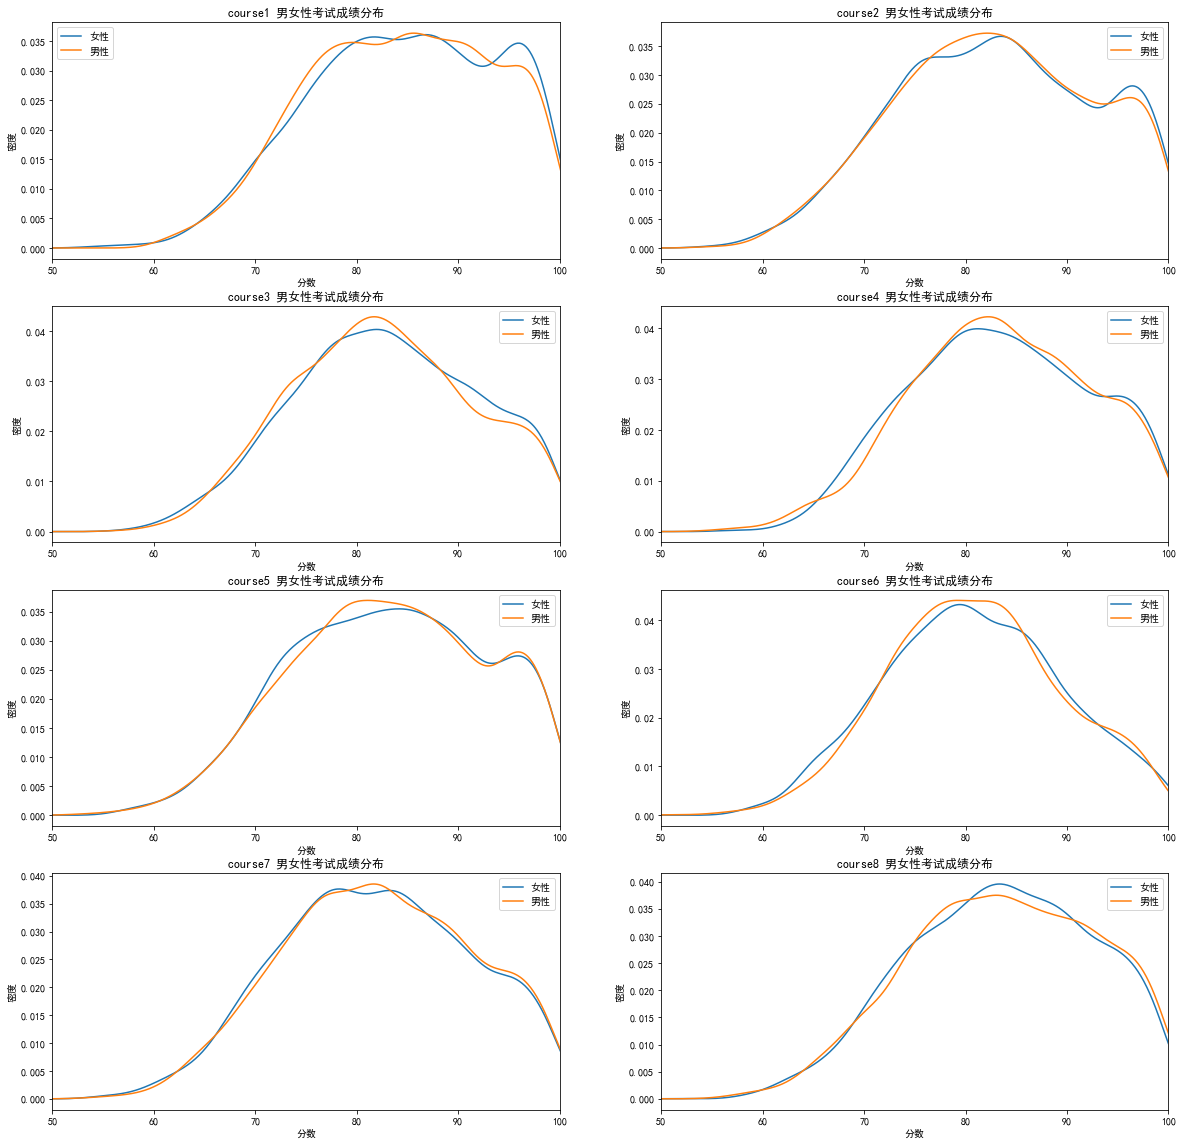

In [18]:
fig = plt.figure(figsize=(20, 20))
fig.set(alpha=0.2) #设定图表颜色alpha参数

pic_tuple = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]

for pic_position, course_id in zip(pic_tuple, course_list):
    plt.subplot2grid((4,2), pic_position) #在一张大图里分列几个小图
    final_train_data.score[final_train_data.gender==0][final_train_data.course == course_id].plot(kind='kde')
    final_train_data.score[final_train_data.gender==1][final_train_data.course == course_id].plot(kind='kde')
    plt.xlabel(u"分数")
    plt.ylabel(u"密度")
    plt.title(course_id + u" 男女性考试成绩分布")
    plt.xlim(50, 100)
    plt.legend((u"女性", u'男性'), loc='best')

结论：不同性别在部分科目里还是有一定差别的

## 2、不同科目的成绩分布 

In [19]:
def score_category(score):
    '''对分数进行聚合，变成A、B、C、D、E五种'''
    if score>=90:
        return 'A'
    elif score>=80:
        return 'B'
    elif score>=70:
        return 'C'
    elif score>=60:
        return 'D'
    else:
        return 'E'

final_train_data['score_grade'] = final_train_data['score'].apply(score_category)
final_train_data.head()

,student_id,course,exam_id,score,last_score,last_rank,sum_complexity,C1,C2,C3,...,term_course_sn,exam_range,knowledge_count,exam_number,exam_type,term,gender,total_rank_score,total_rank,score_grade
0,230748,course1,pNdxJnEf,67,67,477.0,175,0,0,0,...,1,term7_1,6,65,small,term7,0,76.876923,401.0,D
1,186851,course1,pNdxJnEf,74,74,395.0,175,0,0,0,...,1,term7_1,6,65,small,term7,0,86.068702,173.0,C
2,478370,course1,pNdxJnEf,74,74,395.0,175,0,0,0,...,1,term7_1,6,65,small,term7,0,80.511450,321.0,C
3,692328,course1,pNdxJnEf,89,89,124.0,175,0,0,0,...,1,term7_1,6,65,small,term7,1,88.847328,110.0,B
4,509128,course1,pNdxJnEf,84,84,213.0,175,0,0,0,...,1,term7_1,6,65,small,term7,0,83.403101,243.0,B


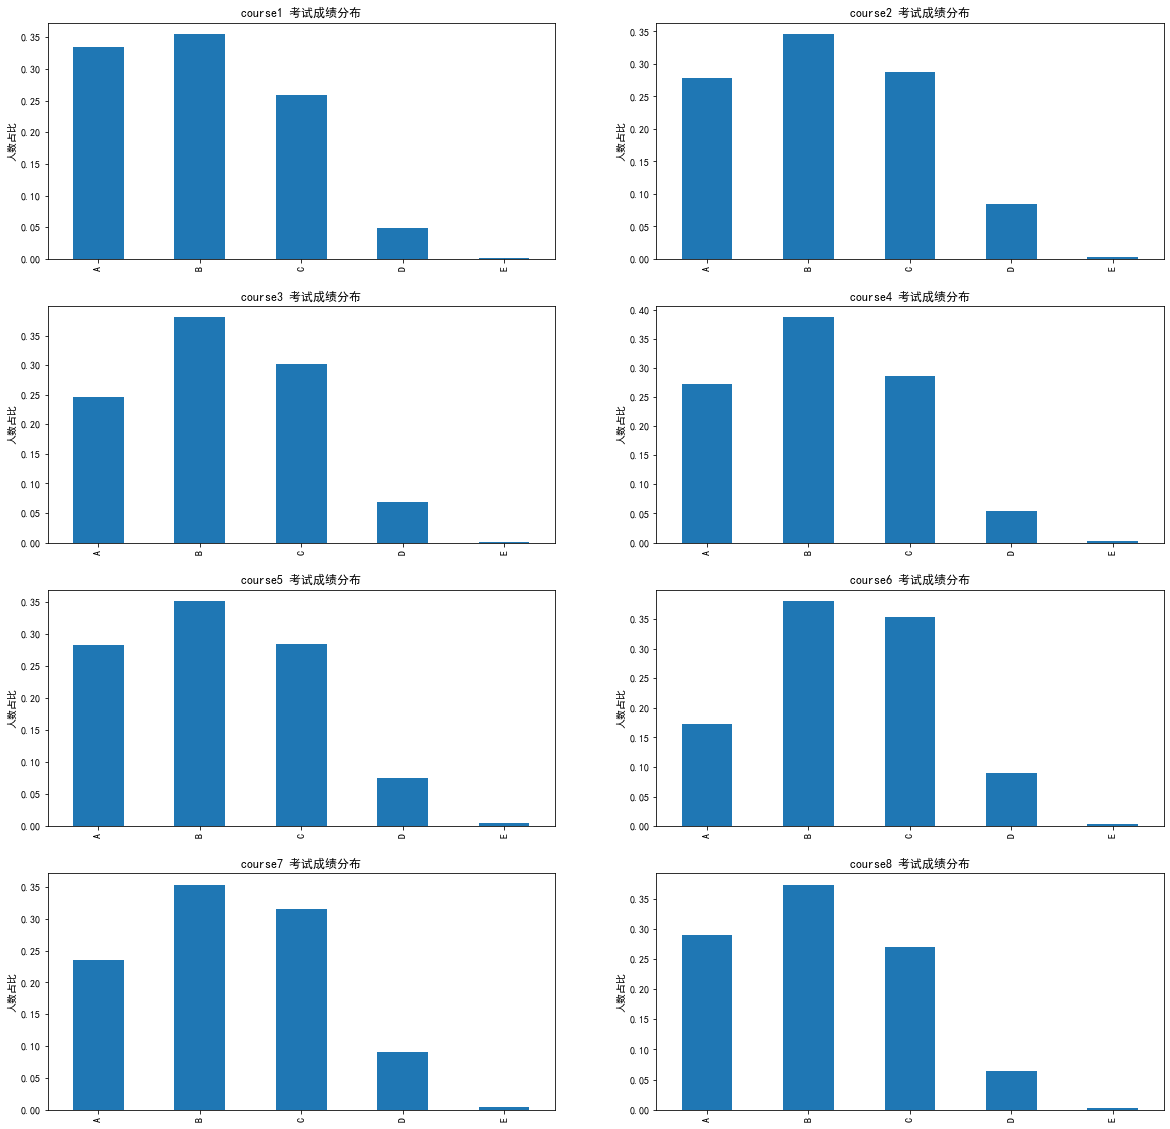

In [20]:
fig = plt.figure(figsize=(20, 20))
fig.set(alpha=0.2) #设定图表颜色alpha参数

for pic_position, course_id in zip(pic_tuple, course_list):
    plt.subplot2grid((4,2), pic_position) #在一张大图里分列几个小图
    score_category_data = final_train_data[final_train_data.course == course_id].score_grade.value_counts(normalize=True).sort_index().plot(kind="bar")
    plt.ylabel(u"人数占比")
    plt.title(course_id + u" 考试成绩分布")

结论：不同课程的考试成绩分布也不同

## 3、考试难度值与平均成绩

Text(0.5, 1.0, ' 难度与考试平均成绩')

<Figure size 1440x1440 with 0 Axes>

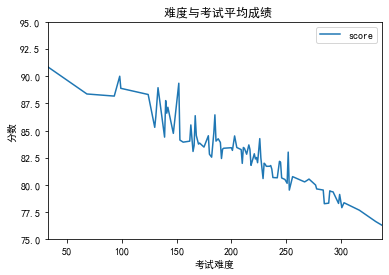

In [21]:
fig = plt.figure(figsize=(20, 20))
fig.set(alpha=0.2) #设定图表颜色alpha参数

complexity_data = final_train_data.pivot_table(index='sum_complexity', values='score', aggfunc=np.mean).sort_index()
complexity_data.plot()
plt.xlabel(u"考试难度")
plt.ylabel(u"分数")
plt.ylim(75, 95)
plt.title(u" 难度与考试平均成绩")

结论：随着难度系数的增加，一般来说考试平均成绩都会下降

# 八、模型建立

1、因为不同科目的category并不相同，所以尝试对不同科目分别建模

In [22]:
import pandas as pd
import numpy as np

#这边导入导出，一是方便以后模型操作，二是可以直接批量转换格式
final_train_data = pd.read_csv('final_train_data.csv')
final_test_data = pd.read_csv('final_test_data.csv')

final_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65350 entries, 0 to 65349
Data columns (total 29 columns):
student_id          65350 non-null int64
course              65350 non-null object
exam_id             65350 non-null object
score               65350 non-null int64
last_score          65350 non-null int64
last_rank           65350 non-null float64
sum_complexity      65350 non-null int64
C1                  65350 non-null int64
C2                  65350 non-null int64
C3                  65350 non-null int64
C4                  65350 non-null int64
C5                  65350 non-null int64
C6                  65350 non-null int64
C7                  65350 non-null int64
C8                  65350 non-null int64
level_0             65350 non-null int64
level_1             65350 non-null int64
level_2             65350 non-null int64
level_3             65350 non-null int64
level_4             65350 non-null int64
term_course_sn      65350 non-null int64
exam_range          65350 

In [ ]:
#先标准化
# from sklearn.preprocessing import StandardScaler

# normal_list = ['sum_complexity', 'exam_number', 'gender', 'std_score', 'avg_score',
#                'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 
#                'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# scaler = StandardScaler()
# scaler.fit(final_train_data[normal_list])
# final_train_data[normal_list] = scaler.transform(final_train_data[normal_list])
# final_test_data[normal_list] = scaler.transform(final_test_data[normal_list])
# final_test_data.head()

In [23]:
# 先LabelEncoder
from sklearn.preprocessing import LabelEncoder
for col in ['course', 'exam_range', 'exam_type', 'term']:
    le = LabelEncoder()
    le.fit(final_train_data[col])
    final_train_data[col] = le.transform(final_train_data[col])
    final_test_data[col] = le.transform(final_test_data[col])
final_train_data.head()

,student_id,course,exam_id,score,last_score,last_rank,sum_complexity,C1,C2,C3,...,level_4,term_course_sn,exam_range,knowledge_count,exam_number,exam_type,term,gender,total_rank_score,total_rank
0,230748,0,pNdxJnEf,67,67,477.0,175,0,0,0,...,0,1,0,6,65,2,0,0,76.876923,401.0
1,186851,0,pNdxJnEf,74,74,395.0,175,0,0,0,...,0,1,0,6,65,2,0,0,86.068702,173.0
2,478370,0,pNdxJnEf,74,74,395.0,175,0,0,0,...,0,1,0,6,65,2,0,0,80.511450,321.0
3,692328,0,pNdxJnEf,89,89,124.0,175,0,0,0,...,0,1,0,6,65,2,0,1,88.847328,110.0
4,509128,0,pNdxJnEf,84,84,213.0,175,0,0,0,...,0,1,0,6,65,2,0,0,83.403101,243.0


In [ ]:
#把course做一下get_dummies
# final_train_data = pd.get_dummies(final_train_data, columns=['course'])
# final_test_data = pd.get_dummies(final_test_data, columns=['course'])
# final_test_data.head()

In [24]:
final_test_data.columns

Index(['student_id', 'course', 'exam_id', 'pred', 'last_score', 'last_rank',
       'sum_complexity', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'term_course_sn',
       'exam_range', 'knowledge_count', 'exam_number', 'exam_type', 'term',
       'gender', 'total_rank_score', 'total_rank'],
      dtype='object')

In [25]:
#10、数据预测（lightgbm）方法一：直接跑，主要是用来测试数据
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# course、last_rank、total_rank、term_S1:term_S11、level_0:level_4、sum_complexity、term、exam_number、term_C1:term_C5、exam_type

dataSet_new = ['course', 'sum_complexity', 'exam_number', 'gender', 'exam_type', 'term', 'total_rank',
               'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'last_score', 'last_rank',
               'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

seed = 36

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 35, #目前最佳:seed=36, num_leaves=35
    'learning_rate': 0.01,
    'is_unbalance': True
}

X_train, X_val, y_train, y_val = train_test_split(final_train_data[dataSet_new], final_train_data['score'], 
                test_size=0.2, random_state=seed)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
model = lgb.train(params, 
                  train_data, 
                  num_boost_round=10000, 
                  valid_sets=val_data, 
                  early_stopping_rounds=20, 
                  categorical_feature = ['course', 'exam_type', 'gender', 'term'],
                  verbose_eval=1000)
pred = model.predict(final_test_data[dataSet_new])
final_test_data['pred'] = pred
final_test_data2 = final_test_data[['student_id', 'course', 'exam_id', 'pred']]

from sklearn.metrics import mean_squared_error

true_answer = pd.read_csv('last2_exam_score.csv', engine='python')
mse = mean_squared_error(y_pred=final_test_data2['pred'], y_true=true_answer['score'])
rmse = np.sqrt(mse)
final_score = 10 * np.log10(rmse)
print(final_score)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['course', 'exam_type', 'gender', 'term']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[1000]	valid_0's rmse: 3.97809
Early stopping, best iteration is:
[1765]	valid_0's rmse: 3.96331
7.424009171540148
